# 02 - Feature Engineering

**Étapes:**
1. Charger les données brutes
2. Nettoyer (supprimer NaN et valeurs saturées)
3. Créer les features (temporelles + ratios)
4. Encoder la saison (one-hot)
5. Préparer le dataset submission

In [ ]:
import sys
sys.path.append('..')

from src.paths import (
    WATER_QUALITY_FILE, LANDSAT_FILE, TERRACLIMATE_FILE,
    SUBMISSION_TEMPLATE, LANDSAT_SUBMISSION_FILE, TERRACLIMATE_SUBMISSION_FILE
)
from src.config import TARGETS, ALL_FEATURES, LANDSAT_FEATURES
from src.data.load_data import load_all, load_submission
from src.features import prepare_training, prepare_submission, MODEL_FEATURES, select_model_features
from src.visualization import plot_correlation

## 1. Charger les données brutes

In [ ]:
_, _, _, df_raw = load_all(
    str(WATER_QUALITY_FILE),
    str(LANDSAT_FILE),
    str(TERRACLIMATE_FILE),
    features=ALL_FEATURES,
    fill_na=False
)

CHARGEMENT DES DONNÉES
[OK] Water quality: 9319 lignes
[OK] Landsat: 9319 lignes, 13 colonnes
[OK] TerraClimate: 9319 lignes
[OK] Données fusionnées: 9319 lignes, 26 colonnes

Valeurs manquantes:

10 colonnes avec des valeurs manquantes:
  - blue: 1371 manquants (14.7%)
  - green: 814 manquants (8.7%)
  - red: 1371 manquants (14.7%)
  - nir: 814 manquants (8.7%)
  - swir16: 814 manquants (8.7%)
  - swir22: 814 manquants (8.7%)
  - NDVI: 1371 manquants (14.7%)
  - NDWI: 814 manquants (8.7%)
  - NDMI: 814 manquants (8.7%)
  - MNDWI: 814 manquants (8.7%)
[OK] 162 sites uniques identifiés
[OK] X: 9319 lignes, 20 features
[OK] y: 9319 lignes, 3 targets

PRÊT!


## 2. Préparer les données training

In [ ]:
# Pipeline: nettoie + crée features + encode season
df_train, medians = prepare_training(df_raw)

print(f"\nDataset training: {len(df_train)} lignes")
print(f"Colonnes: {list(df_train.columns)}")

Nettoyage: 9319 -> 7932 lignes

Dataset training: 7932 lignes
Colonnes: ['Latitude', 'Longitude', 'Sample Date', 'Total Alkalinity', 'Electrical Conductance', 'Dissolved Reactive Phosphorus', 'blue', 'green', 'red', 'nir', 'swir16', 'swir22', 'NDVI', 'NDWI', 'NDMI', 'MNDWI', 'pet', 'aet', 'ppt', 'tmax', 'tmin', 'soil', 'def', 'pdsi', 'vpd', 'ws', 'day_of_year', 'nir_green_ratio', 'swir_ratio', 'season_spring', 'season_summer', 'season_winter']


## 3. Corrélations

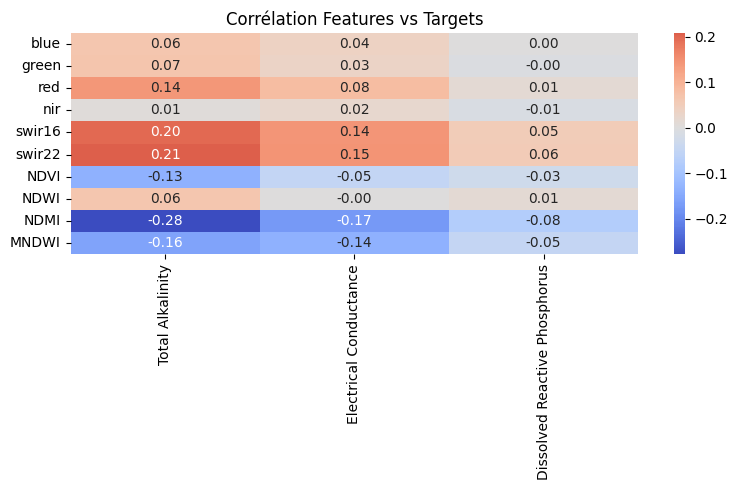

In [ ]:
# Corrélation features Landsat vs targets
plot_correlation(df_train, LANDSAT_FEATURES)

c:\Documents\DATA SCIENCE\PROJET EY\notebooks\..\src\visualization\plots.py:26: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


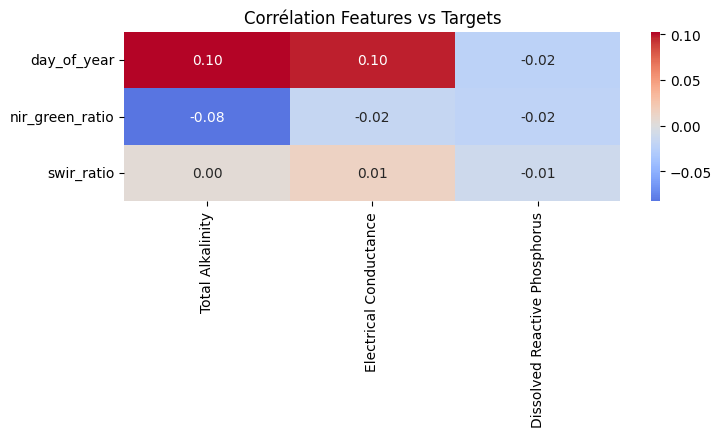

In [ ]:
# Corrélation nouvelles features vs targets
plot_correlation(df_train, ['day_of_year', 'nir_green_ratio', 'swir_ratio'])

## 4. Préparer les données submission

In [ ]:
# Charger submission brut
_, df_sub_raw = load_submission(
    str(SUBMISSION_TEMPLATE),
    str(LANDSAT_SUBMISSION_FILE),
    str(TERRACLIMATE_SUBMISSION_FILE),
    features=ALL_FEATURES,
    fill_na=False
)

# Pipeline: impute + crée features + encode season
df_submission = prepare_submission(df_sub_raw, medians)

print(f"\nDataset submission: {len(df_submission)} lignes")

CHARGEMENT DES DONNÉES DE SUBMISSION
[OK] Submission template: 200 lignes
[OK] Landsat: 200 lignes, 13 colonnes
[OK] TerraClimate: 200 lignes
[OK] Données fusionnées: 200 lignes, 26 colonnes

Valeurs manquantes:

13 colonnes avec des valeurs manquantes:
  - Total Alkalinity: 200 manquants (100.0%)
  - Electrical Conductance: 200 manquants (100.0%)
  - Dissolved Reactive Phosphorus: 200 manquants (100.0%)
  - blue: 27 manquants (13.5%)
  - green: 27 manquants (13.5%)
  - red: 27 manquants (13.5%)
  - nir: 27 manquants (13.5%)
  - swir16: 27 manquants (13.5%)
  - swir22: 27 manquants (13.5%)
  - NDVI: 27 manquants (13.5%)
  - NDWI: 27 manquants (13.5%)
  - NDMI: 27 manquants (13.5%)
  - MNDWI: 27 manquants (13.5%)
[OK] X: 200 lignes, 20 features

PRÊT POUR LA PRÉDICTION!

Dataset submission: 200 lignes


## 5. Résumé

In [ ]:
print("Features pour le modèle:")
print(MODEL_FEATURES)

print(f"\nTraining: {len(df_train)} lignes")
print(f"Submission: {len(df_submission)} lignes")

Features pour le modèle:
['blue', 'green', 'red', 'nir', 'swir16', 'swir22', 'NDVI', 'NDWI', 'NDMI', 'MNDWI', 'pet', 'aet', 'ppt', 'tmax', 'tmin', 'soil', 'def', 'pdsi', 'vpd', 'ws', 'day_of_year', 'nir_green_ratio', 'swir_ratio', 'season_spring', 'season_summer', 'season_winter']

Training: 7932 lignes
Submission: 200 lignes
